In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import timedelta
import pandas as pd
import numpy as np
import warnings
import os.path
import swifter
import pickle
import copy
import sys
import re
warnings.filterwarnings('ignore')

# Local Modules
sys.path.insert(0, os.path.abspath('~/PycharmProjects/platform_migrations/'))
from helpers.regression_helpers import get_slice_date_venue, set_intervention_stuff, get_coms
from helpers.regression_helpers import regression_helper, get_content_helper
from helpers.vars import interventions, interventions_helper, int_ls, int_c, grace_period, exclude_dates
from helpers.plot import plot_intervention, set_size

exclude_dates2 = copy.deepcopy(exclude_dates)
exclude_dates2["/r/Incels"].append([pd.to_datetime("2017-12-03"), pd.to_datetime("2017-12-03")] )

In [3]:
# Latex Configuration
from matplotlib.patches import FancyArrowPatch
import matplotlib.font_manager as font_manager
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates
import os

def handle_10(x):
    if "[10^{-3}]" not in x:
        return x
    x = x.replace("[10^{-3}]", "")
    
    pos = x.find("^")
    x = x + r'\times 10^{-3}'
    return x

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'serif',
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
    'text.usetex': False
    }

mpl.rcParams.update(params)
DATA_PATH = "/Users/horta/PycharmProjects/platform_migrations/"

# Activity

In [4]:
df_all = pd.read_csv("./data/reproducibility_data/activity_agg.csv")
df_all["date_post"] = pd.to_datetime(df_all["date_post"])

In [5]:
df_all = df_all.rename({
    "first": "newcomers",
    "id": "num_posts",
    "author": "num_users",
    "idpauthor": "num_posts_per_user"
}, axis=1)

## Regression table 3a

In [6]:
# This does all regression! ~Magic~
np.random.seed(12)

df_table, df_all = regression_helper(df_all, 
    venues=["/r/The_Donald", "/r/Incels"],
    vals=["num_posts", "num_users", "num_posts_per_user", "newcomers"],
    exclude_dates=exclude_dates,
    grace_period=grace_period,
     name_v="activity",
    round_val=5)

tmp = df_table.copy(deep=True)

map_y_order = {
"newcomers": 4,
"num_posts": 3,
"num_users": 2,
"num_posts_per_user": 1
}

tmp["vals"] = tmp.val.apply(lambda x: map_y_order[x])


map_y = {
    "newcomers": "\#newcomers",
    "num_posts": "\#posts",
    "num_users": "\#users",
    "num_posts_per_user": "\#posts/\#users",
}
tmp["val"] = tmp.val.apply(lambda x: map_y[x])
# tmp["$\gamma$"] = "-"

tmp = tmp.sort_values(["venue", "vals"], ascending=False)

tmp = tmp[["venue", "val", "Intercept", "date_idx", "intervention_flag", "date_idx:intervention_flag", 
           "rsquared"]]

tmp.Intercept = tmp.Intercept.apply(lambda x: x[:x.find("}")]+"}$")
tmp = tmp.rename({"val": "Statistic", 
            "venue": "Venue", 
            "rsquared": "$R^2$",
           "Intercept": r'$\alpha_0$',
           "date_idx": r'$\beta_0$',
           "intervention_flag": r'$\alpha$',
           "date_idx:intervention_flag": r'$\beta$', 
           }, axis=1)

print(tmp.set_index(["Venue", "Statistic"]).to_latex(escape=False))
tmp.set_index(["Venue", "Statistic"])

\begin{tabular}{lllllll}
\toprule
          &                 &     $\alpha_0$ &                    $\beta_0$ &                         $\alpha$ &                      $\beta$ &   $R^2$ \\
Venue & Statistic &                &                              &                                  &                              &         \\
\midrule
/r/The_Donald & \#newcomers &  $214.7^{***}$ &        $-0.5^{} (-1.3, 0.2)$ &     $-77.8^{**} (-127.9, -27.7)$ &         $0.5^{} (-0.5, 1.4)$ &  $0.24$ \\
          & \#posts &  $26650^{***}$ &       $8.8^{} (-17.9, 35.5)$ &  $-14416^{***} (-16947, -11886)$ &  $120.6^{***} (83.9, 157.2)$ &  $0.41$ \\
          & \#users &   $7593^{***}$ &           $4^{} (-0.5, 8.5)$ &     $-4774^{***} (-5184, -4365)$ &     $13.7^{***} (8.1, 19.3)$ &  $0.85$ \\
          & \#posts/\#users &    $3.5^{***}$ &  $-0.001^{} (-0.003, 0.001)$ &           $1.1^{***} (0.9, 1.3)$ &  $0.009^{***} (0.006, 0.01)$ &  $0.85$ \\
/r/Incels & \#newcomers &  $224.9^{***}$ &       $0.9

$\alpha_0$                    $\beta_0$  \
Venue         Statistic                                                     
/r/The_Donald \#newcomers      $214.7^{***}$        $-0.5^{} (-1.3, 0.2)$   
              \#posts          $26650^{***}$       $8.8^{} (-17.9, 35.5)$   
              \#users           $7593^{***}$           $4^{} (-0.5, 8.5)$   
              \#posts/\#users    $3.5^{***}$  $-0.001^{} (-0.003, 0.001)$   
/r/Incels     \#newcomers      $224.9^{***}$       $0.9^{***} (0.5, 1.4)$   
              \#posts           $4840^{***}$      $19.5^{***} (14.1, 25)$   
              \#users          $960.1^{***}$       $3.9^{***} (2.9, 4.9)$   
              \#posts/\#users      $5^{***}$  $-0.001^{} (-0.003, 0.003)$   

                                                      $\alpha$  \
Venue         Statistic                                          
/r/The_Donald \#newcomers         $-77.8^{**} (-127.9, -27.7)$   
              \#posts          $-14416^{***} (-16947, -11886)$   
              \#users             $-4774^{***} (-5184, -4365)$   
              \#posts/\#users           $1.1^{***} (0.9, 1.3)$   
/r/Incels     \#newcomers      $-215.4^{***} (-250.3, -180.5)$   
              \#posts             $-2651^{***} (-3098, -2203)$   
              \#users          $-777.4^{***} (-850.2, -704.6)$   
              \#posts/\#users           $7.4^{***} (6.6, 8.3)$   

                                                   $\beta$   $R^2$  
Venue         Statistic                                             
/r/The_Donald \#newcomers             $0.5^{} (-0.5, 1.4)$  $0.24$  
              \#posts          $120.6^{***} (83.9, 157.2)$  $0.41$  
              \#users             $13.7^{***} (8.1, 19.3)$  $0.85$  
              \#posts/\#users  $0.009^{***} (0.006, 0.01)$  $0.85$  
/r/Incels     \#newcomers        $-0.9^{***} (-1.3, -0.4)$  $0.84$  
              \#posts                 $1.7^{} (-4.8, 8.2)$  $0.55$  
              \#users                $-3^{***} (-4, -2.1)$  $0.93$  
              \#posts/\#users    $0.04^{***} (0.02, 0.05)$  $0.92$

## Figure 3

/r/The_Donald newcomers mean_before 255.69230769230768 intercept_pct -0.3042719614921781
/r/The_Donald num_posts mean_before 26277.931623931625 intercept_pct -0.5485972110099859
/r/The_Donald num_users mean_before 7395.598290598291 intercept_pct -0.6455191064215836
/r/The_Donald num_posts_per_user mean_before 3.5300314300670257 intercept_pct 0.31161195637827904
/r/Incels newcomers mean_before 151.98058252427185 intercept_pct -1.4172863165963971
/r/Incels num_posts mean_before 3612.1650485436894 intercept_pct -0.7339088785737515
/r/Incels num_users mean_before 669.7184466019418 intercept_pct -1.1607863034748698
/r/Incels num_posts_per_user mean_before 6.009445945928105 intercept_pct 1.2313947186785348


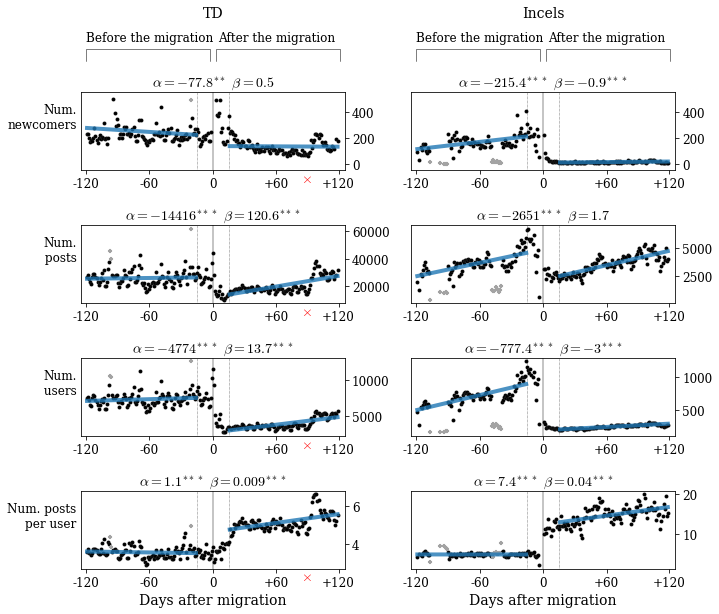

In [7]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8.5), sharex=False, gridspec_kw={"wspace":0.25, "hspace":0.7})
table_helper = df_table.set_index(["val", "venue"])

for idx, venue in enumerate(["/r/The_Donald", "/r/Incels"]):
    community = df_all.loc[df_all.venue == venue]
    coms = get_coms(venue, exclude_dates, community)

    for com, marker in zip(coms, ["o", "."]):
        for idy, val in enumerate(["newcomers", "num_posts", "num_users", "num_posts_per_user"]):

            trans = transforms.blended_transform_factory(
            axs[idy, idx].transData, axs[idy, idx].transAxes)
            axs[idy, idx].scatter(com.date_post, com[val], s=15,  
                                  marker="o"if marker=="o" else "P",
                                  alpha=1, linewidths=0.1,#"white",
                                  c="black" if marker=="o" else "#a3a3a3", edgecolors="#a3a3a3")
            axs[idy, idx].plot(com.date_post, com[val + "reg" + venue + "1"], color="tab:blue", lw=4, 
                               alpha=0.8, zorder=4)
            rsquared = table_helper.loc[val,venue].rsquared
            slope = table_helper.loc[val,venue]["date_idx:intervention_flag"].split(";")[0]
            intercept = table_helper.loc[val,venue].intervention_flag.split(";")[0]

            if marker == "o":             

                print(venue, val,
                      "mean_before", np.mean(com[val].values[:len(com)//2]),
                      "intercept_pct", float(re.sub("(\$|\{|\*|\^|\})", "",
                                                    intercept.split("(")[0]))/np.mean(com[val].values[:len(com)//2])
                     )
            
                plt.text(interventions[venue]["Measure"], 1.08, 
                         r"$\alpha=$" + intercept[:intercept.find("(")] + "$" +
                         r" $\beta=$" + slope[:slope.find("(")] + "$",
                         transform=trans, ha='center', size=14)

                if idy == 0:
                    axs[idy, idx].plot([interventions[venue]["Measure"] - timedelta(days=3),
                                        interventions[venue]["Measure"] - timedelta(days=3),
                                        interventions[venue]["Measure"] - timedelta(days=120),
                                       interventions[venue]["Measure"] - timedelta(days=120)],
                             [1.4, 1.55, 1.55, 1.4], transform=trans, clip_on=False, color="black", lw=0.5)
                    axs[idy, idx].plot([interventions[venue]["Measure"] + timedelta(days=3),
                                        interventions[venue]["Measure"] + timedelta(days=3),
                                        interventions[venue]["Measure"] + timedelta(days=120),
                                       interventions[venue]["Measure"] + timedelta(days=120)],
                             [1.4, 1.55, 1.55, 1.4], transform=trans, clip_on=False, color="black", lw=0.5)
                    
                    plt.text(interventions[venue]["Measure"] + timedelta(days=60), 1.65, 
                            "After the migration",
                             transform=trans, ha='center', size=12)
                    plt.text(interventions[venue]["Measure"] - timedelta(days=60), 1.65, 
                            "Before the migration",
                             transform=trans, ha='center', size=12)
            axs[idy, idx].yaxis.tick_right()

    for i in range(4): 
        plot_intervention(axs[i, idx], interventions, venue, "all", interventions_helper, int_ls, int_c, grace_period)
tdm = interventions["/r/The_Donald"]["Measure"]
tdi = interventions["/r/Incels"]["Measure"]
tdelta = timedelta(days=60)
for i in range(4):
    axs[i, 0].set_xticks([tdm -2*tdelta, tdm - tdelta, tdm, tdm + tdelta, tdm + 2*tdelta - timedelta(days=1)])
    axs[i, 1].set_xticks([tdi -2*tdelta, tdi - tdelta, tdi, tdi + tdelta, tdi + 2*tdelta - timedelta(days=1)])
    axs[i, 0].set_xlim([tdm -2*tdelta - timedelta(days=5), tdm + 2*tdelta + timedelta(days=5)])
    axs[i, 1].set_xlim([tdi -2*tdelta - timedelta(days=5), tdi + 2*tdelta + timedelta(days=5)])
    axs[i, 0].set_xticklabels(["-120", "-60", "0", "+60", "+120"])
    axs[i, 1].set_xticklabels(["-120", "-60", "0", "+60", "+120"])
#     axs[i, 0].xaxis.set_major_formatter(mpl.dates.DateFormatter("%d %b %y"))
#     axs[i, 1].xaxis.set_major_formatter(mpl.dates.DateFormatter("%d %b %y"))
axs[0, 0].set_title("TD", pad=75, size=14)
axs[0, 1].set_title("Incels", pad=75, size=14)
axs[1, 0].set_ylabel('Num.\n posts', rotation=0, ha="right", size=12)
axs[2, 0].set_ylabel('Num.\n users', rotation=0, ha="right", size=12)
axs[3, 0].set_ylabel('Num. posts\nper user', rotation=0, ha="right", size=12)
axs[0, 0].set_ylabel('Num.\nnewcomers', rotation=0, ha="right", size=12)
axs[0, 0].set_ylim([-50, 550])
axs[0, 1].set_ylim([-50, 550])

axs[3, 0].set_xlabel("Days after migration")
axs[3, 1].set_xlabel("Days after migration")

for i in range(0, 4):
    trans = transforms.blended_transform_factory(axs[i, 0].transData, axs[i, 0].transAxes)
    plt.text(pd.to_datetime("25-05-2020"), -0.15, r'$\times$', ha="center", color="red", transform=trans)


set_size(fig, (10, 8.5))
fig.savefig(DATA_PATH + "images/rdd_activity.pdf", bbox_inches="tight")

# Content

In [8]:
df_content = pd.read_csv("./data/reproducibility_data/content_agg.csv")
df_norm = pd.read_csv("./data/reproducibility_data/content_agg_fixation_dict.csv")

df_content["date_post"] = pd.to_datetime(df_content["date_post"])
df_norm["date_post"] = pd.to_datetime(df_norm["date_post"])

df_content_matched = pd.read_csv("./data/reproducibility_data/content_matched_agg.csv")
df_norm_matched = pd.read_csv("./data/reproducibility_data/content_matched_agg_fixation_dict.csv")

df_content_matched["date_post"] = pd.to_datetime(df_content_matched["date_post"])
df_norm_matched["date_post"] = pd.to_datetime(df_norm_matched["date_post"])

In [9]:
df_content

,venue,date_post,SEVERE_TOXICITY,SEVERE_TOXICITY80p,fixation_dict_incels,fixation_dict_td,NegativeEmotion,CoreHostility,We,They,fixation_dict_incels_norm,fixation_dict_td_norm,NegativeEmotion_norm,CoreHostility_norm,We_norm,They_norm,length,count_repeated,intervention_flag,date_idx
0,/r/Incels,2017-07-11,27.790798,5.492889,2.226466,0.082108,2.925339,4.890204,0.662593,1.437846,0.022543,0.000572,0.037348,0.064596,0.007004,0.010917,84.0,52370,0,-119
1,/r/Incels,2017-07-12,26.041248,3.871829,2.352458,0.041065,3.115100,4.886777,1.108765,2.182330,0.025100,0.000184,0.034184,0.057667,0.008276,0.014648,68.0,17046,0,-118
2,/r/Incels,2017-07-13,27.030192,4.703161,2.210764,0.038672,2.768289,4.572994,0.825008,1.582340,0.025530,0.000236,0.036799,0.062556,0.007075,0.013063,81.0,31030,0,-117
3,/r/Incels,2017-07-14,25.741291,5.088496,2.102152,0.116116,2.743052,4.413916,0.583596,1.390376,0.024064,0.001347,0.033082,0.055759,0.005490,0.010907,80.0,66313,0,-116
4,/r/Incels,2017-07-15,25.863340,4.419446,1.845054,0.067326,2.832502,4.743279,0.432810,1.187824,0.021582,0.000946,0.033604,0.058876,0.004751,0.009706,81.0,62383,0,-115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,/r/The_Donald,2020-06-19,20.290058,2.408899,0.184536,0.436563,2.339560,3.086820,0.932530,1.904909,0.002560,0.004538,0.027191,0.040694,0.008005,0.016021,79.0,680085,1,114
459,/r/The_Donald,2020-06-20,19.487212,2.147622,0.173795,0.441370,2.327792,2.959291,0.945505,1.846781,0.002374,0.004295,0.026994,0.039767,0.008317,0.015459,75.0,544894,1,115
460,/r/The_Donald,2020-06-21,18.946969,2.090090,0.172453,0.436773,2.359060,2.861591,0.964770,1.855078,0.002601,0.004381,0.026795,0.037337,0.007989,0.015169,80.0,620459,1,116
461,/r/The_Donald,2020-06-22,19.929855,1.957337,0.136634,0.449611,2.315416,2.891954,0.959817,1.887719,0.002065,0.004603,0.025609,0.036613,0.008318,0.015568,83.0,679921,1,117


## Regression Table 3b and 3c

In [10]:
# This does all regression! ~Magic~

np.random.seed(9876789)

tmp_vals = ['fixation_dict_incels', 'fixation_dict_td', "We", "They" ]

df_table_con, df_content = regression_helper(
    df_content, 
    venues=["/r/The_Donald", "/r/Incels"],
    vals=tmp_vals,
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=7,
    name_v="content"
)

np.random.seed(9876789)

df_table_norm, df_norm = regression_helper(
    df_norm, 
    venues=["/r/The_Donald", "/r/Incels"],
    vals=["SEVERE_TOXICITY80p", "CoreHostility", "NegativeEmotion"],
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=5,
    name_v="content",
)

# Matched version

np.random.seed(345345)

tmp_vals = ['fixation_dict_incels', 'fixation_dict_td', "We", "They" ]

df_table_con_matched, df_content_matched = regression_helper(
    df_content_matched, 
    venues=["/r/The_Donald", "/r/Incels"],
    vals=tmp_vals,
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=7,
    name_v="content_matched"
)

np.random.seed(4564564)

df_table_norm_matched, df_norm_matched = regression_helper(
    df_norm_matched, 
    venues=["/r/The_Donald", "/r/Incels"],
    vals=["SEVERE_TOXICITY80p", "CoreHostility", "NegativeEmotion"],
    exclude_dates=exclude_dates2,
    grace_period=grace_period,
    confounder="length",
    round_val=5,
    name_v="content_matched",
)


In [12]:
tmp = ["SEVERE_TOXICITY80p", "CoreHostility", "NegativeEmotion"]
x1 = df_table_norm[df_table_norm.val.apply(lambda x: x in tmp)]
x2 = df_table_con[df_table_con.val.apply(lambda x: x not in tmp)]
tmp = pd.concat([x1, x2])#.sort_values(["venue", "val"]).set_index(["venue", "val"])
tmp = tmp[["venue", "val", "Intercept_table", "date_idx_table", "intervention_flag_table", 
           "date_idx:intervention_flag_table", "length_table", "rsquared"]]
tmp = tmp.copy(deep=True)
tmp

map_y_order = {
    "fixation_dict_incels": 7,
    "fixation_dict_td": 6,
    "SEVERE_TOXICITY80p": 5,
    "NegativeEmotion": 4,
    "CoreHostility": 3,
    "We": 2,
    "They": 1,
}

tmp["vals"] = tmp.val.apply(lambda x: map_y_order[x] if x in map_y_order else -1)

tmp = tmp.loc[tmp.vals != -1]
tmp = tmp.loc[~((tmp.vals == 7) & (tmp.venue == "/r/The_Donald")) ]
tmp = tmp.loc[~((tmp.vals == 6) & (tmp.venue == "/r/Incels")) ]
map_y = {
    "fixation_dict_incels": "Fix. Dict",
    "fixation_dict_td":  "Fix. Dict",
    "SEVERE_TOXICITY80p": "Toxicity",
    "NegativeEmotion": "Neg. Emotion",
    "CoreHostility": "Hostility",
    "We": "We",
    "They": "They"
}
tmp["val"] = tmp.val.apply(lambda x: map_y[x])
tmp = tmp.sort_values(["venue", "vals"], ascending=False)

tmp = tmp.rename({"val": "Statistic", 
            "venue": "Venue", 
            "rsquared": "$R^2$",
           "Intercept_table": r'$\alpha_0$',
           "date_idx_table": r'$\beta_0$',
           "intervention_flag_table": r'$\alpha$',
           "date_idx:intervention_flag_table": r'$\beta$',
           "length_table": r'$\gamma$',
           }, axis=1)
tmp = tmp.drop(["vals", "$\gamma$"], axis=1)
print(tmp.set_index(["Venue", "Statistic"]).to_latex(escape=False))
tmp.set_index(["Venue", "Statistic"])

\begin{tabular}{lllllll}
\toprule
          &      &                $\alpha_0$ &                           $\beta_0$ &                   $\alpha$ &                              $\beta$ &   $R^2$ \\
Venue & Statistic &                           &                                     &                            &                                      &         \\
\midrule
/r/The_Donald & Fix. Dict &    $0.6^{***} (0.5, 0.8)$ &      $[10^{-3}] 0.2^{} (-0.2, 0.5)$ &  $-0.2^{***} (-0.3, -0.2)$ &     $[10^{-3}] 1.7^{***} (1.2, 2.2)$ &  $0.53$ \\
          & Toxicity &    $3.1^{***} (2.1, 4.2)$ &        $[10^{-3}] 0.5^{} (-2, 3.1)$ &     $0.9^{***} (0.6, 1.3)$ &  $[10^{-3}] -5.9^{**} (-10.1, -1.7)$ &   $0.3$ \\
          & Neg. Emotion &    $2.7^{***} (2.3, 3.2)$ &    $[10^{-3}] 2.2^{***} (1.1, 3.3)$ &  $-0.2^{**} (-0.3, -0.06)$ &      $[10^{-3}] -0.5^{} (-2.1, 1.1)$ &  $0.14$ \\
          & Hostility &    $3.3^{***} (2.8, 3.8)$ &     $[10^{-3}] 1.2^{} (-0.04, 2.4)$ &    $-0.05^{} (-0.2, 0.09)

$\alpha_0$  \
Venue         Statistic                                
/r/The_Donald Fix. Dict       $0.6^{***} (0.5, 0.8)$   
              Toxicity        $3.1^{***} (2.1, 4.2)$   
              Neg. Emotion    $2.7^{***} (2.3, 3.2)$   
              Hostility       $3.3^{***} (2.8, 3.8)$   
              We              $0.6^{***} (0.3, 0.8)$   
              They            $1.3^{***} (1.1, 1.5)$   
/r/Incels     Fix. Dict       $1.9^{***} (1.6, 2.1)$   
              Toxicity      $11.4^{***} (9.1, 13.8)$   
              Neg. Emotion    $3.2^{***} (2.8, 3.6)$   
              Hostility       $6.3^{***} (5.4, 7.1)$   
              We              $0.6^{***} (0.4, 0.9)$   
              They            $1.2^{***} (0.8, 1.6)$   

                                                     $\beta_0$  \
Venue         Statistic                                          
/r/The_Donald Fix. Dict         $[10^{-3}] 0.2^{} (-0.2, 0.5)$   
              Toxicity            $[10^{-3}] 0.5^{} (-2, 3.1)$   
              Neg. Emotion    $[10^{-3}] 2.2^{***} (1.1, 3.3)$   
              Hostility        $[10^{-3}] 1.2^{} (-0.04, 2.4)$   
              We            $[10^{-3}] -0.7^{**} (-1.2, -0.2)$   
              They             $[10^{-3}] 0.05^{} (-0.5, 0.6)$   
/r/Incels     Fix. Dict      $[10^{-3}] -1.8^{*} (-3.3, -0.4)$   
              Toxicity         $[10^{-3}] 6.9^{} (-3.1, 16.8)$   
              Neg. Emotion        $[10^{-3}] 1^{} (-0.7, 2.7)$   
              Hostility           $[10^{-3}] 0.4^{} (-3.1, 4)$   
              We                 $[10^{-3}] -1^{} (-2.5, 0.4)$   
              They             $[10^{-3}] -0.3^{} (-2.6, 2.1)$   

                                             $\alpha$  \
Venue         Statistic                                 
/r/The_Donald Fix. Dict     $-0.2^{***} (-0.3, -0.2)$   
              Toxicity         $0.9^{***} (0.6, 1.3)$   
              Neg. Emotion  $-0.2^{**} (-0.3, -0.06)$   
              Hostility       $-0.05^{} (-0.2, 0.09)$   
              We               $0.3^{***} (0.2, 0.3)$   
              They          $-0.3^{***} (-0.4, -0.2)$   
/r/Incels     Fix. Dict     $-0.4^{***} (-0.5, -0.2)$   
              Toxicity          $-0.3^{} (-1.2, 0.6)$   
              Neg. Emotion     $-0.1^{} (-0.3, 0.03)$   
              Hostility         $0.05^{} (-0.3, 0.4)$   
              We               $0.06^{} (-0.05, 0.2)$   
              They             $-0.1^{} (-0.3, 0.04)$   

                                                        $\beta$   $R^2$  
Venue         Statistic                                                  
/r/The_Donald Fix. Dict        $[10^{-3}] 1.7^{***} (1.2, 2.2)$  $0.53$  
              Toxicity      $[10^{-3}] -5.9^{**} (-10.1, -1.7)$   $0.3$  
              Neg. Emotion      $[10^{-3}] -0.5^{} (-2.1, 1.1)$  $0.14$  
              Hostility           $[10^{-3}] -0.1^{} (-2, 1.8)$  $0.08$  
              We            $[10^{-3}] -2.1^{***} (-2.7, -1.4)$  $0.46$  
              They             $[10^{-3}] 4.8^{***} (3.8, 5.7)$  $0.55$  
/r/Incels     Fix. Dict         $[10^{-3}] 2.4^{**} (0.9, 3.8)$  $0.69$  
              Toxicity         $[10^{-3}] -1.9^{} (-13.7, 9.9)$  $0.13$  
              Neg. Emotion       $[10^{-3}] 1.3^{} (-0.4, 3.1)$  $0.25$  
              Hostility          $[10^{-3}] 2.6^{} (-0.8, 6.1)$  $0.38$  
              We                $[10^{-3}] -0.4^{} (-1.3, 0.5)$   $0.3$  
              They              $[10^{-3}] -0.2^{} (-1.6, 1.2)$  $0.44$

In [13]:
tmp = ["SEVERE_TOXICITY80p", "CoreHostility", "NegativeEmotion"]
x1 = df_table_norm_matched[df_table_norm_matched.val.apply(lambda x: x in tmp)]
x2 = df_table_con_matched[df_table_con_matched.val.apply(lambda x: x not in tmp)]
tmp = pd.concat([x1, x2])#.sort_values(["venue", "val"]).set_index(["venue", "val"])
tmp = tmp[["venue", "val", "Intercept_table", "date_idx_table", "intervention_flag_table", 
           "date_idx:intervention_flag_table", "length_table", "rsquared"]]
tmp = tmp.copy(deep=True)
tmp

map_y_order = {
    "fixation_dict_incels": 7,
    "fixation_dict_td": 6,
    "SEVERE_TOXICITY80p": 5,
    "NegativeEmotion": 4,
    "CoreHostility": 3,
    "We": 2,
    "They": 1,
}

tmp["vals"] = tmp.val.apply(lambda x: map_y_order[x] if x in map_y_order else -1)

tmp = tmp.loc[tmp.vals != -1]
tmp = tmp.loc[~((tmp.vals == 7) & (tmp.venue == "/r/The_Donald")) ]
tmp = tmp.loc[~((tmp.vals == 6) & (tmp.venue == "/r/Incels")) ]
map_y = {
    "fixation_dict_incels": "Fix. Dict",
    "fixation_dict_td":  "Fix. Dict",
    "SEVERE_TOXICITY80p": "Toxicity",
    "NegativeEmotion": "Neg. Emotion",
    "CoreHostility": "Hostility",
    "We": "We",
    "They": "They"
}
tmp["val"] = tmp.val.apply(lambda x: map_y[x])
tmp = tmp.sort_values(["venue", "vals"], ascending=False)

tmp
# tmp.Intercept = tmp.Intercept.apply(lambda x: x[:x.find("}")]+"}$")
tmp = tmp.rename({"val": "Statistic", 
            "venue": "Venue", 
            "rsquared": "$R^2$",
           "Intercept_table": r'$\alpha_0$',
           "date_idx_table": r'$\beta_0$',
           "intervention_flag_table": r'$\alpha$',
           "date_idx:intervention_flag_table": r'$\beta$',
           "length_table": r'$\gamma$',
           }, axis=1)
tmp = tmp.drop(["vals", "$\gamma$"], axis=1)
print(tmp.set_index(["Venue", "Statistic"]).to_latex(escape=False))
tmp.set_index(["Venue", "Statistic"])

\begin{tabular}{lllllll}
\toprule
          &      &              $\alpha_0$ &                          $\beta_0$ &                   $\alpha$ &                              $\beta$ &   $R^2$ \\
Venue & Statistic &                         &                                    &                            &                                      &         \\
\midrule
/r/The_Donald & Fix. Dict &  $0.6^{***} (0.5, 0.8)$ &     $[10^{-3}] 0.2^{} (-0.2, 0.5)$ &  $-0.2^{***} (-0.3, -0.2)$ &     $[10^{-3}] 1.6^{***} (1.1, 2.1)$ &  $0.54$ \\
          & Toxicity &  $3.2^{***} (2.1, 4.3)$ &       $[10^{-3}] 0.6^{} (-2.8, 4)$ &      $0.7^{**} (0.2, 1.2)$ &        $[10^{-3}] -2.4^{} (-9, 4.3)$ &  $0.13$ \\
          & Neg. Emotion &  $2.5^{***} (2.2, 2.8)$ &     $[10^{-3}] 0.5^{} (-0.5, 1.6)$ &    $-0.1^{} (-0.2, 0.006)$ &      $[10^{-3}] 1.7^{*} (0.06, 3.3)$ &  $0.08$ \\
          & Hostility &  $3.1^{***} (2.7, 3.5)$ &     $[10^{-3}] 0.1^{} (-1.4, 1.6)$ &     $-0.1^{} (-0.3, 0.04)$ &       $[10^{-3

$\alpha_0$  \
Venue         Statistic                              
/r/The_Donald Fix. Dict     $0.6^{***} (0.5, 0.8)$   
              Toxicity      $3.2^{***} (2.1, 4.3)$   
              Neg. Emotion  $2.5^{***} (2.2, 2.8)$   
              Hostility     $3.1^{***} (2.7, 3.5)$   
              We            $0.5^{***} (0.2, 0.8)$   
              They          $1.6^{***} (1.3, 1.8)$   
/r/Incels     Fix. Dict     $1.9^{***} (1.6, 2.2)$   
              Toxicity      $11^{***} (7.9, 14.1)$   
              Neg. Emotion    $3^{***} (2.6, 3.4)$   
              Hostility       $6^{***} (5.3, 6.7)$   
              We            $0.4^{***} (0.3, 0.6)$   
              They          $0.9^{***} (0.7, 1.2)$   

                                                    $\beta_0$  \
Venue         Statistic                                         
/r/The_Donald Fix. Dict        $[10^{-3}] 0.2^{} (-0.2, 0.5)$   
              Toxicity           $[10^{-3}] 0.6^{} (-2.8, 4)$   
              Neg. Emotion     $[10^{-3}] 0.5^{} (-0.5, 1.6)$   
              Hostility        $[10^{-3}] 0.1^{} (-1.4, 1.6)$   
              We            $[10^{-3}] -0.6^{} (-1.2, 0.007)$   
              They             $[10^{-3}] 0.1^{} (-0.6, 0.8)$   
/r/Incels     Fix. Dict     $[10^{-3}] -2.1^{*} (-3.9, -0.4)$   
              Toxicity               $0.01^{} (-0.008, 0.03)$   
              Neg. Emotion       $[10^{-3}] 0.3^{} (-3, 3.7)$   
              Hostility        $[10^{-3}] 0.7^{} (-3.9, 5.3)$   
              We               $[10^{-3}] 0.6^{} (-0.6, 1.8)$   
              They            $[10^{-3}] 0.04^{} (-1.7, 1.8)$   

                                             $\alpha$  \
Venue         Statistic                                 
/r/The_Donald Fix. Dict     $-0.2^{***} (-0.3, -0.2)$   
              Toxicity          $0.7^{**} (0.2, 1.2)$   
              Neg. Emotion    $-0.1^{} (-0.2, 0.006)$   
              Hostility        $-0.1^{} (-0.3, 0.04)$   
              We               $0.2^{***} (0.2, 0.3)$   
              They          $-0.3^{***} (-0.4, -0.2)$   
/r/Incels     Fix. Dict     $-0.4^{***} (-0.6, -0.2)$   
              Toxicity        $-1.7^{*} (-3.2, -0.1)$   
              Neg. Emotion   $-0.3^{*} (-0.5, -0.04)$   
              Hostility      $-0.5^{*} (-0.9, -0.06)$   
              We            $-0.2^{***} (-0.3, -0.1)$   
              They          $-0.2^{**} (-0.3, -0.04)$   

                                                        $\beta$   $R^2$  
Venue         Statistic                                                  
/r/The_Donald Fix. Dict        $[10^{-3}] 1.6^{***} (1.1, 2.1)$  $0.54$  
              Toxicity            $[10^{-3}] -2.4^{} (-9, 4.3)$  $0.13$  
              Neg. Emotion      $[10^{-3}] 1.7^{*} (0.06, 3.3)$  $0.08$  
              Hostility          $[10^{-3}] 2.5^{} (-0.001, 5)$  $0.06$  
              We            $[10^{-3}] -2.2^{***} (-2.9, -1.4)$  $0.37$  
              They             $[10^{-3}] 4.5^{***} (3.4, 5.6)$  $0.44$  
/r/Incels     Fix. Dict          $[10^{-3}] 1.4^{} (-0.9, 3.6)$  $0.68$  
              Toxicity                 $0.01^{} (-0.007, 0.04)$  $0.08$  
              Neg. Emotion       $[10^{-3}] 4.2^{*} (0.6, 7.8)$   $0.1$  
              Hostility         $[10^{-3}] 9.5^{***} (4, 15.1)$   $0.2$  
              We                  $[10^{-3}] -0.3^{} (-1.5, 1)$  $0.44$  
              They               $[10^{-3}] 0.8^{} (-1.2, 2.8)$  $0.28$

## Figures 6 and 8

/r/The_Donald fixation_dict_td mean_before 0.4589394267778693 intercept_pct -0.43578735739520974
/r/The_Donald We mean_before 0.902311116239362 intercept_pct 0.3324795567745361
/r/The_Donald They mean_before 1.6802115814411709 intercept_pct -0.17854894187949857
/r/Incels fixation_dict_incels mean_before 1.9329144620045748 intercept_pct -0.20694138714507343
/r/Incels We mean_before 0.5835850297940732 intercept_pct 0.10281278123459045
/r/Incels They mean_before 1.3963635919734316 intercept_pct -0.071614585609951
/r/The_Donald SEVERE_TOXICITY80p mean_before 2.1317063426908724 intercept_pct 0.4221969893207344
/r/The_Donald CoreHostility mean_before 2.610336212567021 intercept_pct -0.019154620680387254
/r/The_Donald NegativeEmotion mean_before 2.2666862803750143 intercept_pct -0.08823453061484574
/r/Incels SEVERE_TOXICITY80p mean_before 9.034720099450283 intercept_pct -0.03320523455045978
/r/Incels CoreHostility mean_before 4.9514536018014335 intercept_pct 0.010098044740196908
/r/Incels Neg

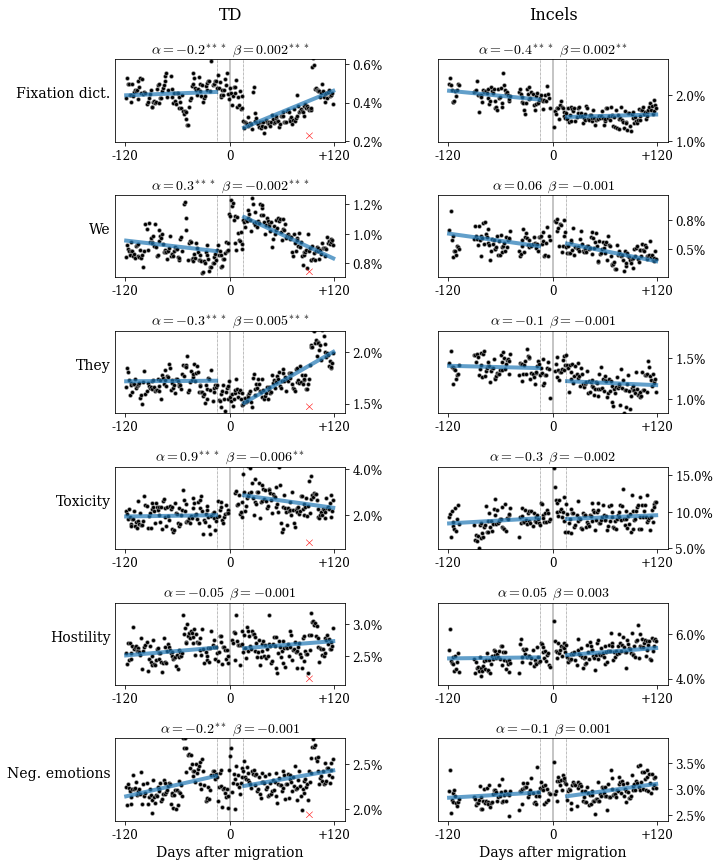

/r/The_Donald fixation_dict_td mean_before 0.4589394267778693 intercept_pct -0.43578735739520974
/r/The_Donald We mean_before 0.902311116239362 intercept_pct 0.22165303784969076
/r/The_Donald They mean_before 1.6802115814411709 intercept_pct -0.17854894187949857
/r/Incels fixation_dict_incels mean_before 1.9329144620045748 intercept_pct -0.20694138714507343
/r/Incels We mean_before 0.5835850297940732 intercept_pct -0.34270927078196817
/r/Incels They mean_before 1.3963635919734316 intercept_pct -0.143229171219902
/r/The_Donald SEVERE_TOXICITY80p mean_before 2.1317063426908724 intercept_pct 0.3283754361383489
/r/The_Donald CoreHostility mean_before 2.610336212567021 intercept_pct -0.03830924136077451
/r/The_Donald NegativeEmotion mean_before 2.2666862803750143 intercept_pct -0.04411726530742287
/r/Incels SEVERE_TOXICITY80p mean_before 9.034720099450283 intercept_pct -0.18816299578593879
/r/Incels CoreHostility mean_before 4.9514536018014335 intercept_pct -0.10098044740196908
/r/Incels Ne

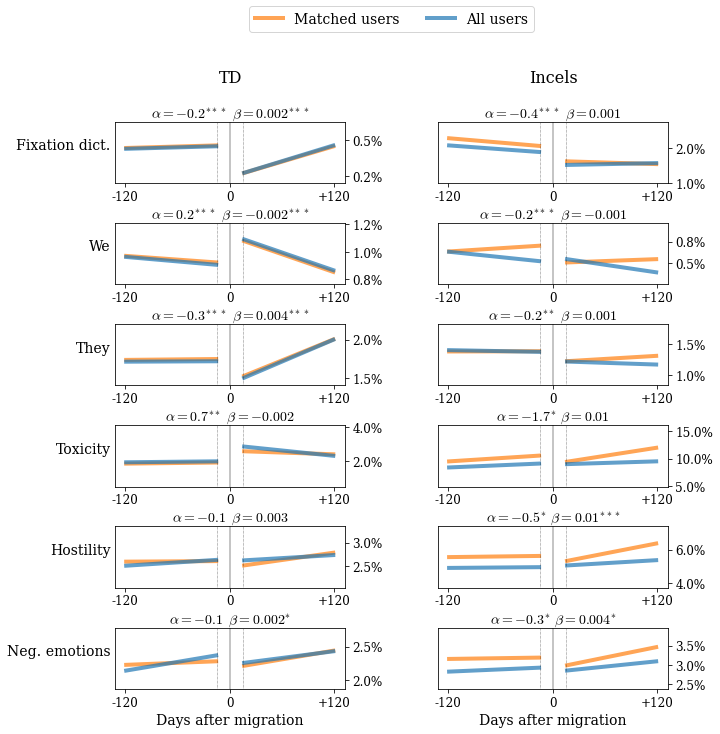

In [14]:
for plot_kind in ["normal", "matched"]:
    
    if plot_kind == "normal":
        fig, axs_ = plt.subplots(6, 2, figsize=(10, 12),gridspec_kw={"wspace":0.4, "hspace":0.65})
    else:
        fig, axs_ = plt.subplots(6, 2, figsize=(10, 9.3),gridspec_kw={"wspace":0.4, "hspace":0.65})


    for df_tmp, df_table, df_tmp_matched, df_table_matched, vars_to_plot, title_vars, fig_name, axs in zip(
        [df_content, df_norm],
        [df_table_con, df_table_norm],
        [df_content_matched, df_norm_matched],
        [df_table_con_matched, df_table_norm_matched],
        [["fixdict", 'We', 'They'], ["SEVERE_TOXICITY80p", "CoreHostility", "NegativeEmotion"]],
        [["Fixation dict.", "We", "They"], ["Toxicity", "Hostility", "Neg. emotions"]],
        ["_1", "_2"],
        [axs_[:3, :], axs_[3:, :] ]):


        table_helper = df_table.set_index(["val", "venue"])
        table_helper2 = df_table_matched.set_index(["val", "venue"])


        for idx, venue in enumerate(["/r/The_Donald", "/r/Incels"]):

            community = df_tmp.loc[df_tmp.venue == venue]
            community2 = df_tmp_matched.loc[df_tmp_matched.venue == venue]
            com = get_coms(venue, exclude_dates2, community)[0]
            com2 = get_coms(venue, exclude_dates2, community2)[0]
            marker = "o"

            for idy, val in enumerate(vars_to_plot):

                if val == "fixdict":
                    if venue == "/r/The_Donald":
                        val = "fixation_dict_td"
                    else:
                        val = "fixation_dict_incels"

                trans = transforms.blended_transform_factory(axs[idy, idx].transData, axs[idy, idx].transAxes)
    
                if plot_kind == "normal":
                    axs[idy, idx].scatter(com.date_post, com[val], s=15,  marker="o", alpha=1, linewidths=0.5,
                                          c="black" if marker=="o" else "tab:gray",  edgecolors="#a3a3a3")
                    axs[idy, idx].plot(com.date_post, com[val + "reg" + venue + "1"], color="tab:blue", 
                                       lw=4, alpha=0.7)
                    th = table_helper
                    
                if plot_kind == "matched":
                    axs[idy, idx].plot(com2.date_post, com2[val + "reg" + venue + "1"], color="tab:orange", 
                                       lw=4, alpha=0.7, label="Matched users")
                    axs[idy, idx].plot(com.date_post, com[val + "reg" + venue + "1"], color="tab:blue", 
                                       lw=4, alpha=0.7, label="All users")
                    th = table_helper2


                tmpx = com[["date_post", val + "reg" + venue + str(1), val]].dropna()
                tmpx2 = com2[["date_post", val + "reg" + venue + str(1), val]].dropna()

                # Get aligned y-ticks

                valsylim = tmpx[val].quantile([0.05, 0.95]).values
                valsylim2 = tmpx2[val].quantile([0.05, 0.95]).values
                valsylim = (min(valsylim[0], valsylim2[0]), max(valsylim[1], valsylim2[1]))
                dyvalsylim = 0.27 *(valsylim[1] - valsylim[0])
                valsylim = [valsylim[0] - dyvalsylim,  valsylim[1] + dyvalsylim ]
                axs[idy, idx].set_ylim(valsylim)
                axs[idy, idx].yaxis.tick_right()

                rsquared = th.loc[val,venue].rsquared
                slope_0 = th.loc[val,venue]["date_idx"].split(";")[0]
                intercept_0 = th.loc[val,venue]["Intercept"].split(";")[0]
                slope = th.loc[val,venue]["date_idx:intervention_flag"].split(";")[0]
                intercept = th.loc[val,venue].intervention_flag.split(";")[0]
                plt.text(interventions[venue]["Measure"], 1.08, 
                         r"$\alpha=$" + handle_10(intercept[:intercept.find("(")]) + "$" +
                         r" $\beta=$" + handle_10(slope[:slope.find("(")]) + "$",
                         transform=trans, ha='center', size=14)
                print(venue, val,
                    "mean_before", np.mean(com[val].values[:len(com)//2]),
                    "intercept_pct", float(re.sub("(\$|\{|\*|\^|\})", "", 
                                                  intercept.split("(")[0]))/np.mean(com[val].values[:len(com)//2])
                    )
            for i in range(3):
                plot_intervention(axs[i, idx], interventions, venue, "all",
                                  interventions_helper, int_ls, int_c, grace_period)

        tdm = interventions["/r/The_Donald"]["Measure"]
        tdi = interventions["/r/Incels"]["Measure"]
        tdelta = timedelta(days=120)

        for idx in range(3):
            axs[idx, 0].set_xlim([tdm - tdelta - timedelta(days=12), tdm + tdelta + timedelta(days=12)])
            axs[idx, 0].set_xticks([tdm - tdelta, tdm, tdm + tdelta - timedelta(days=1)])
            axs[idx, 1].set_xticks([tdi - tdelta, tdi, tdi + tdelta - timedelta(days=1)])
            axs[idx, 1].set_xlim([tdi - tdelta - timedelta(days=12), tdi + tdelta + timedelta(days=12)])
            axs[idx, 0].set_xticklabels(["-120", "0", "+120"])
            axs[idx, 1].set_xticklabels(["-120", "0", "+120"])

            axs[idx, 0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))
            axs[idx, 1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))


        for i in range(3):
            axs[i, 0].set_ylabel(title_vars[i], size=14, rotation=0, ha="right")
            if plot_kind == "normal":
                trans = transforms.blended_transform_factory(axs[i, 0].transData, axs[i, 0].transAxes)
                plt.text(pd.to_datetime("25-05-2020"), 0.01, r'$\times$', ha="center", 
                         va="bottom", color="red", transform=trans)

    axs_[0, 0].set_title("TD", size=16, pad=40)
    axs_[0, 1].set_title("Incels", size=16, pad=40)
    axs_[-1, 0].set_xlabel("Days after migration")
    axs_[-1, 1].set_xlabel("Days after migration")
    
    if plot_kind == "normal":
        set_size(fig, (10, 12))
    else:
        set_size(fig, (10, 9.3))
        axs_[0, 0].legend(ncol=2,  bbox_to_anchor=(1.2, 3), loc="upper center")

    fig.savefig(DATA_PATH + "images/rdd_toxf_{}.pdf".format(plot_kind), 
                bbox_inches="tight")

    plt.show()

---